# Libraries

In [200]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight



# Loading the Files

Download the csv files into the `data/` directory.

In [185]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)


print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [163]:
print(trainingSet['Score'].value_counts(normalize=True))


Score
5.0    0.533994
4.0    0.225691
3.0    0.118547
1.0    0.061393
2.0    0.060375
Name: proportion, dtype: float64


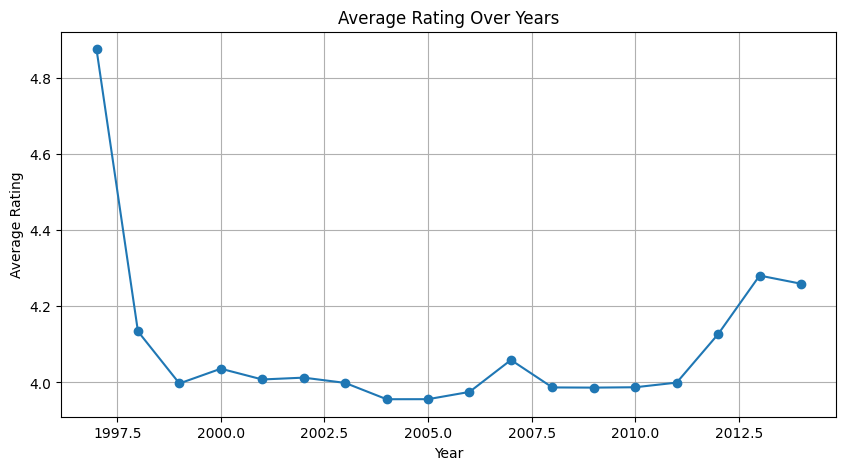

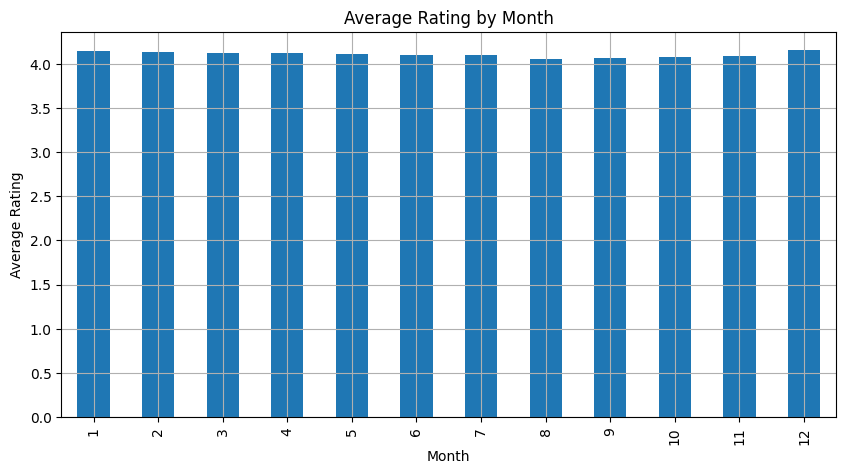

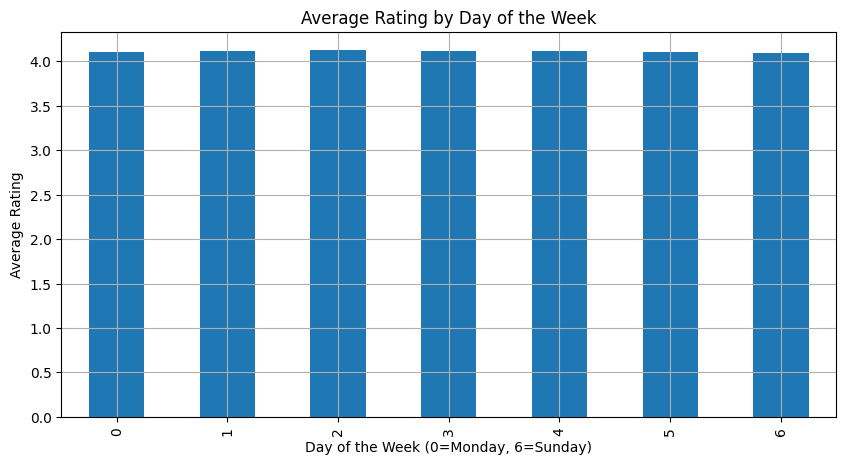

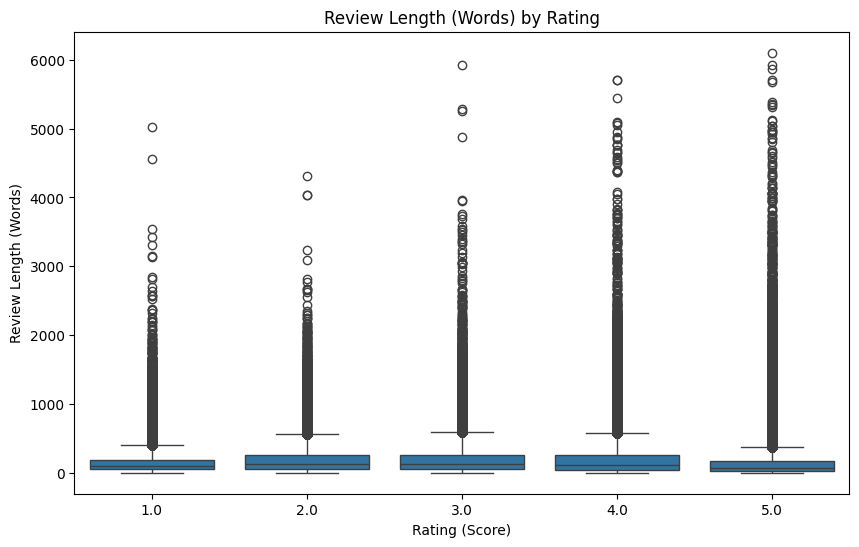

Correlation between Year and Score: 0.08630055248436261


In [204]:
value_count = trainingSet['Score'].value_counts()

trainingSet['Time'] = pd.to_datetime(trainingSet['Time'], unit='s')
trainingSet['Year'] = trainingSet['Time'].dt.year
trainingSet['Month'] = trainingSet['Time'].dt.month
trainingSet['Day'] = trainingSet['Time'].dt.day_of_week

avg_rating_per_year = trainingSet.groupby('Year')['Score'].mean()
avg_rating_per_month = trainingSet.groupby('Month')['Score'].mean()
avg_rating_per_day = trainingSet.groupby('Day')['Score'].mean()

# Plot the average rating over years
plt.figure(figsize=(10, 5))
avg_rating_per_year.plot(kind='line', marker='o')
plt.title('Average Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
avg_rating_per_month.plot(kind='bar')
plt.title('Average Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
avg_rating_per_day.plot(kind='bar')
plt.title('Average Rating by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()



# Calculate the correlation between Year and Score
correlation = trainingSet[['Year', 'Score']].corr().iloc[0, 1]
print(f"Correlation between Year and Score: {correlation}")

    

In [205]:
trainingSet['Review_Length_Words'] = trainingSet['Text'].apply(lambda x: len(x.split()))
#This was used to create the CAP for the clipping in order to get a better understanding of the data without the extreeme 

# Calculate the mean review length
#Also use trainingSet['Review_Length_Words'] = np.clip(trainingSet['Review_Length_Words'], 0, 500)
mean_review_length_overall = trainingSet['Review_Length_Words'].mean()

print("Mean review length (in words) across all reviews:", mean_review_length_overall)

Mean review length (in words) across all reviews: 161.55521807234382


Number of users with more than one review: 123960
Number of products with more than one review: 50052


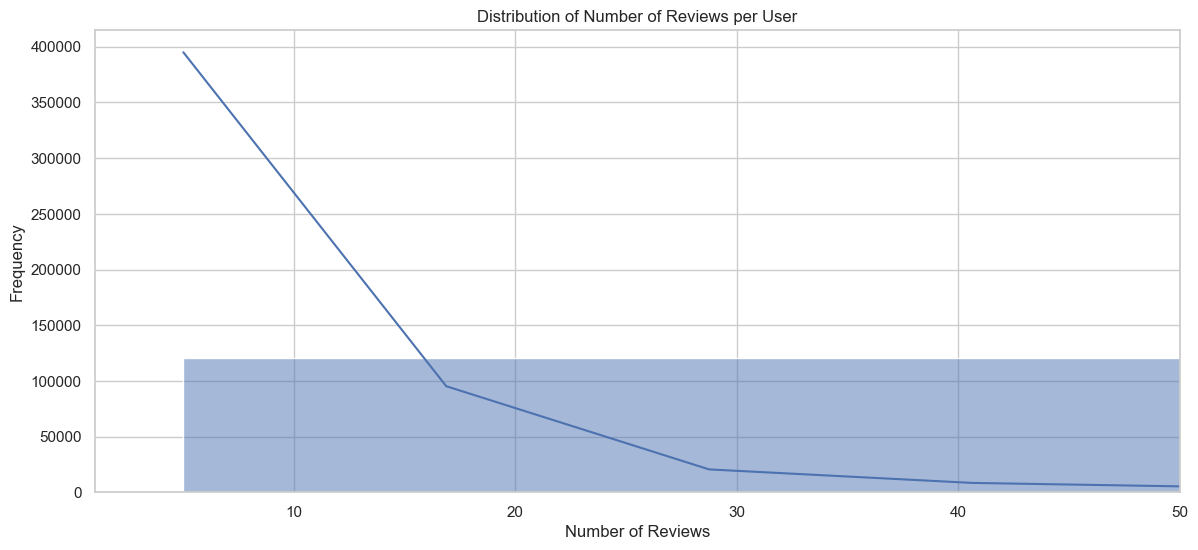

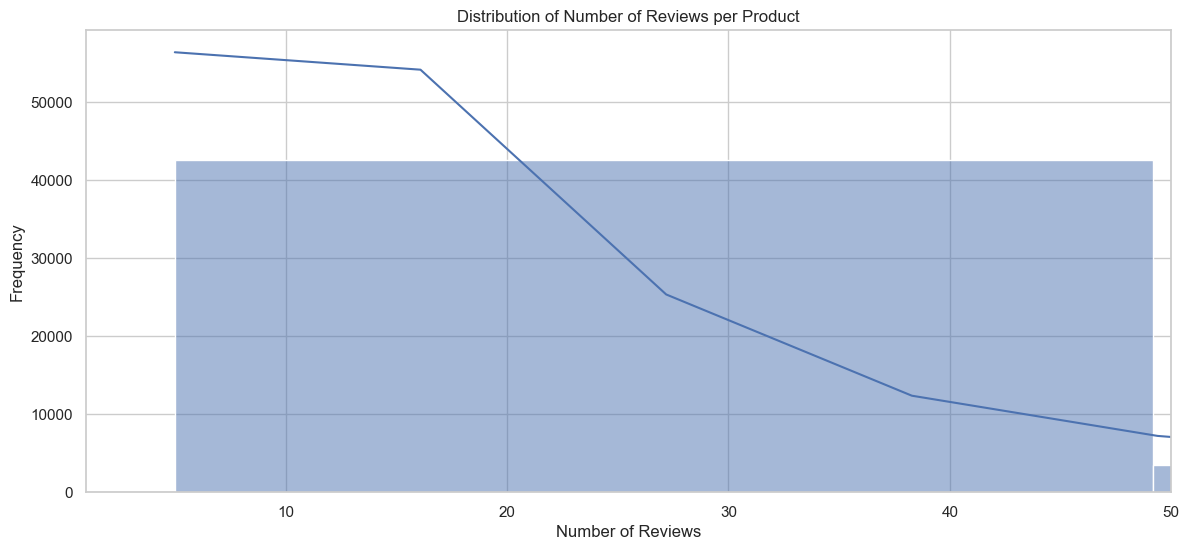

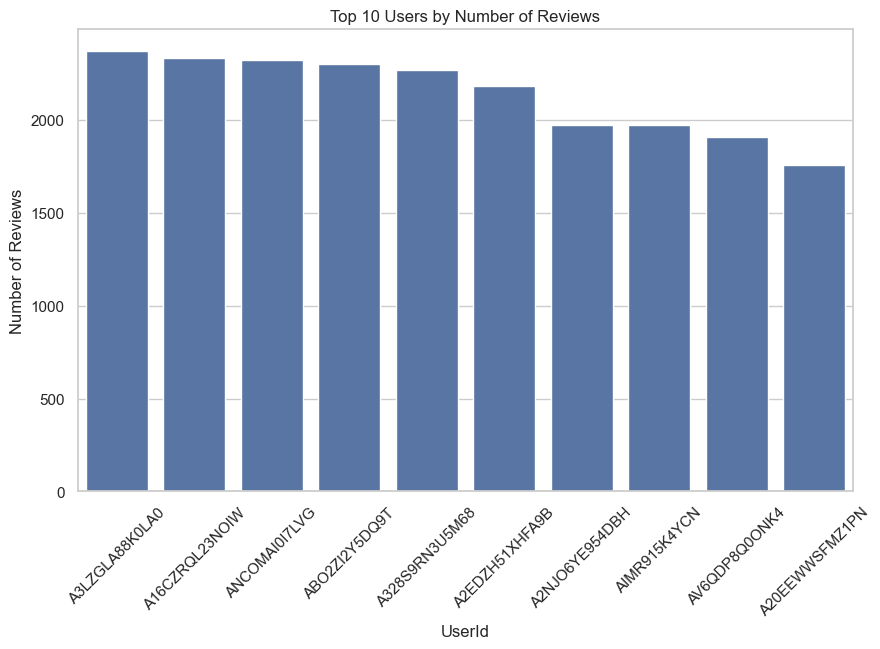

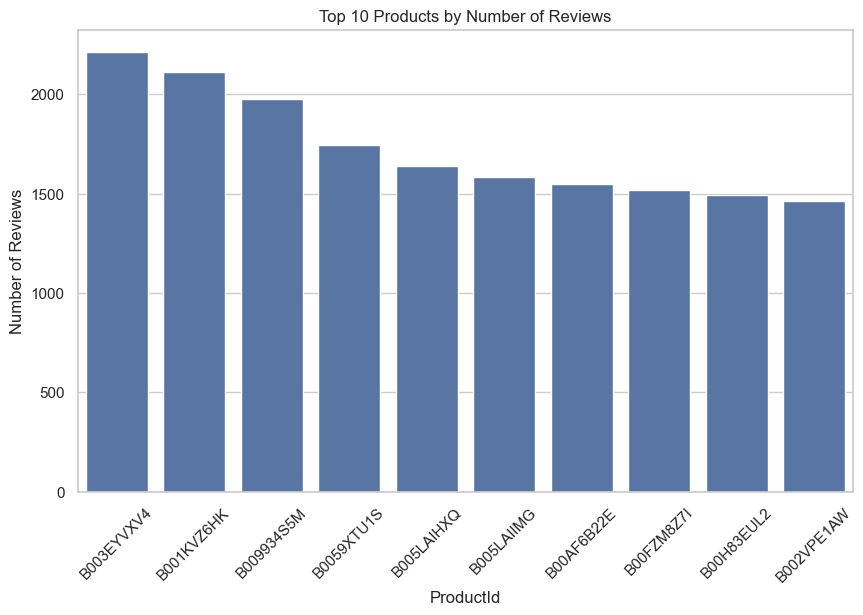

In [210]:
# Group by UserId and count the number of reviews each user has made
user_review_counts = trainingSet.groupby('UserId')['Id'].count()

# Filter users who have more than one review
users_with_multiple_reviews = user_review_counts[user_review_counts > 1]

# Calculate the number of such users
num_users_with_multiple_reviews = len(users_with_multiple_reviews)
print(f"Number of users with more than one review: {num_users_with_multiple_reviews}")


# Group by ProductId and count the number of reviews for each product
product_review_counts = trainingSet.groupby('ProductId')['Id'].count()

# Filter products that have more than one review
products_with_multiple_reviews = product_review_counts[product_review_counts > 1]

# Calculate the number of such products
num_products_with_multiple_reviews = len(products_with_multiple_reviews)
print(f"Number of products with more than one review: {num_products_with_multiple_reviews}")

import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent theme for seaborn
sns.set_theme(style="whitegrid")

# Histogram for the number of reviews per user
plt.figure(figsize=(14, 6))
sns.histplot(user_review_counts, bins=50, kde=True)
plt.title('Distribution of Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.xlim(1, 50)  
plt.show()

# Histogram for the number of reviews per product
plt.figure(figsize=(14, 6))
sns.histplot(product_review_counts, bins=50, kde=True)
plt.title('Distribution of Number of Reviews per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.xlim(1, 50)  
plt.show()

# Bar Plot for top 10 users by review count
top_users = user_review_counts.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_users.index, y=top_users.values)
plt.title('Top 10 Users by Number of Reviews')
plt.xlabel('UserId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

# Bar Plot for top 10 products by review count
top_products = product_review_counts.sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title('Top 10 Products by Number of Reviews')
plt.xlabel('ProductId')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()



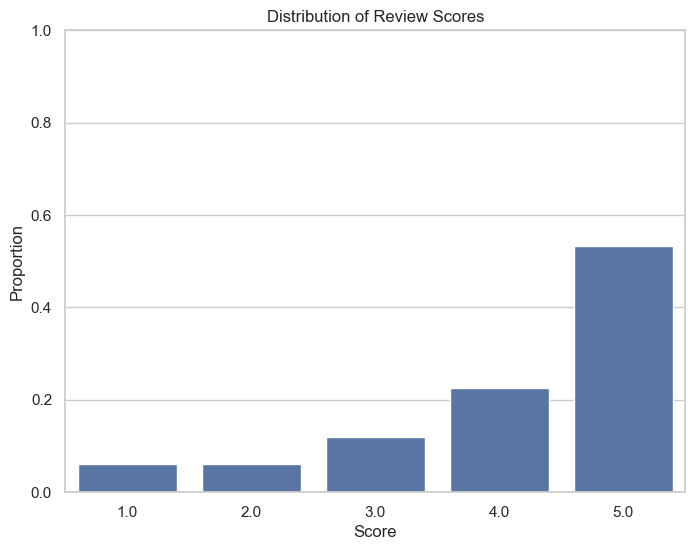

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the normalized value counts for the 'Score' column
score_distribution = trainingSet['Score'].value_counts(normalize=True)

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=score_distribution.index, y=score_distribution.values)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for proportions
plt.show()


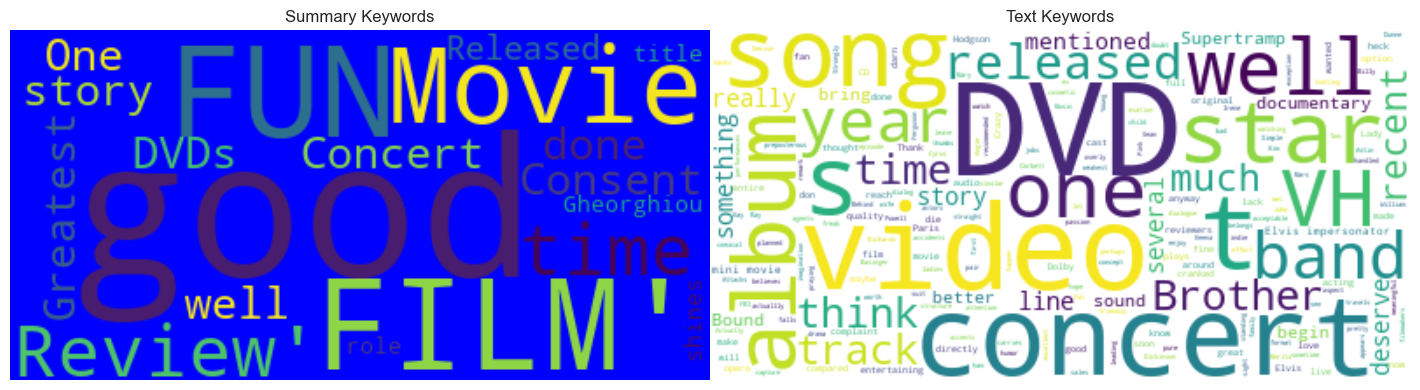

In [214]:
from wordcloud import WordCloud, STOPWORDS
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(121)
text = trainingSet.Summary.values
wordcloud = WordCloud(
    background_color = 'blue',
    stopwords = STOPWORDS).generate(str(text))
plt.title('Summary Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

ax = fig.add_subplot(122)
text = trainingSet.Text.values
wordcloud = WordCloud(
    background_color = 'white',
    stopwords = STOPWORDS).generate(str(text))
plt.title('Text Keywords')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Adding Features

In [123]:
#Analysis for sentiment text analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
"""
lexicon (Is the dictionary with the polarity mapping)
"""
tqdm.pandas()

def review_length(df): 
    df['Review_Length_Words'] = df['Text'].progress_apply(lambda x: len(x.split()))


def textScore(df):
    analyzer = SentimentIntensityAnalyzer()
    df['text_sentiment_score'] = df['Text'].progress_apply(lambda x: analyzer.polarity_scores(str(x))['compound']) #Takes much longer which make sense 
    df['summary_sentiment_score'] = df['Summary'].progress_apply(lambda x: analyzer.polarity_scores(str(x))['compound']) #Takes much shorter time
    
def user_product_rating_mean(df):
    user_mean_ratings = df.groupby('UserId')['Score'].progress_apply(lambda x: x.mean())
    product_mean_ratings = df.groupby('ProductId')['Score'].progress_apply(lambda x: x.mean())
    df['user_mean_rating'] = df['UserId'].map(user_mean_ratings)
    df['product_mean_rating'] = df['ProductId'].map(product_mean_ratings)

    global_mean_score = df['Score'].mean()
    df['user_mean_rating'].fillna(global_mean_score, inplace=True)
    df['product_mean_rating'].fillna(global_mean_score, inplace=True)

def user_product_rating_std(df):
    user_rating_std = df.groupby('UserId')['Score'].progress_apply(lambda x: x.std())
    product_rating_std = df.groupby('ProductId')['Score'].progress_apply(lambda x: x.std())
    df['user_rating_variability'] = df['UserId'].map(user_rating_std)
    df['product_rating_variability'] = df['ProductId'].map(product_rating_std)

    df['user_rating_variability'].fillna(0, inplace=True)
    df['product_rating_variability'].fillna(0, inplace=True)

def extract_year_from_time(df):
    df['review_year'] = pd.to_datetime(df['Time'], unit='s').dt.year
   
    



In [124]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    """
    print("Filling N/a values with empty strings")
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')

    print("Feature engineering the helpfulness")
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Calculate length in terms of number of words
    print("Featuring sentiment scores")
    textScore(df) #Adding sentiment_scores for text (Both for summary and text)

    print("Featuring lenght scores")
    review_length(df) #Adding lenght features to the dataframw

    """
    print("Featuring mean scores for user and product")
    user_product_rating_mean(df)

    print("Featuring std scores for user and product")
    user_product_rating_std(df)

    print("Featuring Year")
    extract_year_from_time(df)

    
    

    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    #train_sample = trainingSet.sample(frac=0.1, random_state=42)
    train = add_features_to(trainingSet)
    print(train.columns)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Featuring mean scores for user and product


100%|██████████| 50052/50052 [00:04<00:00, 10024.76it/s]
/var/folders/8f/cw0n438x3z30fwlbw0y41lkr0000gn/T/ipykernel_33710/3513104870.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['user_mean_rating'].fillna(global_mean_score, inplace=True)
/var/folders/8f/cw0n438x3z30fwlbw0y41lkr0000gn/T/ipykernel_33710/3513104870.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never

Featuring std scores for user and product


100%|██████████| 50052/50052 [00:06<00:00, 7157.62it/s]
/var/folders/8f/cw0n438x3z30fwlbw0y41lkr0000gn/T/ipykernel_33710/3513104870.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['user_rating_variability'].fillna(0, inplace=True)
/var/folders/8f/cw0n438x3z30fwlbw0y41lkr0000gn/T/ipykernel_33710/3513104870.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work beca

Featuring Year
Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Score',
       'Helpfulness', 'text_sentiment_score', 'summary_sentiment_score',
       'Review_Length_Words', 'user_mean_rating', 'product_mean_rating',
       'user_rating_variability', 'product_rating_variability', 'review_year'],
      dtype='object')


# Sample + Split into training and testing set

In [125]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)





Index(['Id', 'ProductId', 'UserId', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Helpfulness',
       'text_sentiment_score', 'summary_sentiment_score',
       'Review_Length_Words', 'user_mean_rating', 'product_mean_rating',
       'user_rating_variability', 'product_rating_variability', 'review_year'],
      dtype='object')


In [162]:

print(Y_train.value_counts(normalize=True))

Score
5.0    0.534217
4.0    0.225688
3.0    0.118411
1.0    0.061296
2.0    0.060388
Name: proportion, dtype: float64


Score
5.0    29756
4.0    12571
3.0     6595
1.0     3414
2.0     3364
Name: count, dtype: int64


# Feature Selection

In [188]:

features = [
    'Helpfulness',  
    'text_sentiment_score', 
    'summary_sentiment_score',
    'Review_Length_Words',
    'user_mean_rating', 
    'product_mean_rating',
    'user_rating_variability', 
    'product_rating_variability', 
]

X_train_select = X_train[features]   #Using the smaller Dataset
X_test_select = X_test[features]
X_submission_select = X_submission[features]

print(X_train_select.shape)
print(X_test_select.columns)
print(Y_train.shape)

(1114005, 8)
Index(['Helpfulness', 'text_sentiment_score', 'summary_sentiment_score',
       'Review_Length_Words', 'user_mean_rating', 'product_mean_rating',
       'user_rating_variability', 'product_rating_variability'],
      dtype='object')
(1114005,)


In [174]:
X_train_sample, _, Y_train_sample, _ = train_test_split(
    X_train[features],
    Y_train,
    test_size=0.95,  # Keep 5% for the sample (0.95 means 95% will be dropped)
    stratify=Y_train,  # Ensures the class distribution is the same as the original
    random_state=42  # For reproducibility
)

In [189]:
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
search_space = {
    'learning_rate': (0.01, 0.1, 'log-uniform'),  # Lower range to avoid overfitting
    'max_depth': (3, 6),  # Shallower trees to reduce overfitting
    'min_samples_split': (2, 20),  # Range for minimum samples to split
    'n_estimators': (100, 500),  # Lower the number of trees for simplicity
    'subsample': (0.6, 1.0),  # Subsampling for diversity among trees
    'min_samples_leaf': (1, 10)  # Add leaf regularization to control tree complexity
}

# Define the Gradient Boosting Classifier with a fixed random state for reproducibility
model = GradientBoostingClassifier(random_state=42, learning_rate=0.02571011142608906, max_depth=5, min_samples_leaf=9, min_samples_split= 8, n_estimators= 368, subsample=0.7656474529942154, verbose=3)


model.fit(X_train_select, Y_train)

y_pred_sample = model.predict(X_test_select)
print(accuracy_score(y_pred_sample, Y_test))


"""
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

bayes_search = BayesSearchCV(
    estimator=model,
    search_spaces=search_space,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=cv,  # Use StratifiedKFold for better evaluation
    scoring='accuracy',  # Scoring metric for evaluation
    n_jobs=-1,  # Use all available cores
    verbose=2,  # Show progress messages
    random_state=42  # For reproducibility
)

bayes_search.fit(X_train_sample, Y_train_sample)
print("Best parameters found:", bayes_search.best_params_)
print("Best cross-validation accuracy:", bayes_search.best_score_)
"""

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2427           0.0216          113.35m
         2           1.2225           0.0181          113.07m
         3           1.2045           0.0185          112.42m
         4           1.1885           0.0189          110.62m
         5           1.1722           0.0132          110.53m
         6           1.1576           0.0142          110.13m
         7           1.1442           0.0145          110.35m
         8           1.1322           0.0155          109.58m
         9           1.1188           0.0073          109.09m
        10           1.1082           0.0140          109.03m
        11           1.0967           0.0088          109.15m
        12           1.0866           0.0108          110.85m
        13           1.0776           0.0121          111.59m
        14           1.0673           0.0066          111.31m
        15           1.0595           0.0119          111.00m
       

'\ncv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)\n\nbayes_search = BayesSearchCV(\n    estimator=model,\n    search_spaces=search_space,\n    n_iter=10,  # Number of parameter settings that are sampled\n    cv=cv,  # Use StratifiedKFold for better evaluation\n    scoring=\'accuracy\',  # Scoring metric for evaluation\n    n_jobs=-1,  # Use all available cores\n    verbose=2,  # Show progress messages\n    random_state=42  # For reproducibility\n)\n\nbayes_search.fit(X_train_sample, Y_train_sample)\nprint("Best parameters found:", bayes_search.best_params_)\nprint("Best cross-validation accuracy:", bayes_search.best_score_)\n'

In [190]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X_train_select.columns,
    'importance': feature_importances
}).sort_values(by='importance', ascending=False)
print(feature_importance_df)

                      feature  importance
4            user_mean_rating    0.425103
6     user_rating_variability    0.167065
5         product_mean_rating    0.160344
2     summary_sentiment_score    0.096502
0                 Helpfulness    0.051396
1        text_sentiment_score    0.050547
7  product_rating_variability    0.041135
3         Review_Length_Words    0.007909


# Model Creation

# Model Evaluation

Accuracy on testing set =  0.6750274683844281


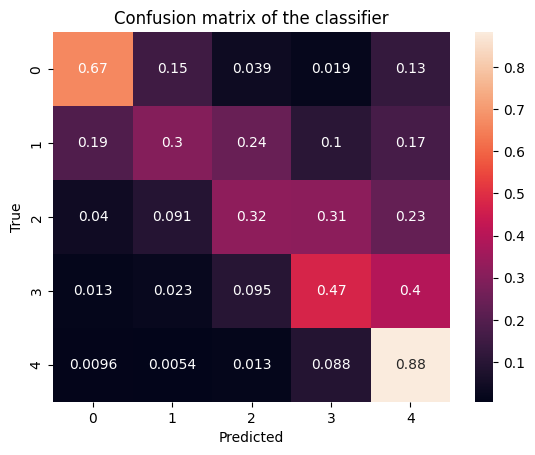

              precision    recall  f1-score   support

         1.0       0.67      0.63      0.65     24240
         2.0       0.30      0.39      0.34     17142
         3.0       0.32      0.45      0.38     31043
         4.0       0.47      0.54      0.50     73799
         5.0       0.88      0.78      0.83    225112

    accuracy                           0.68    371336
   macro avg       0.53      0.56      0.54    371336
weighted avg       0.71      0.68      0.69    371336



In [202]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, y_pred_sample))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, y_pred_sample, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_pred=Y_test, y_true=y_pred_sample))

# Create submission file

In [191]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [157]:
print(X_submission_select.columns)
print(X_train_select.columns)

Index(['Time', 'Helpfulness', 'text_sentiment_score',
       'summary_sentiment_score', 'Review_Length_Words', 'user_mean_rating',
       'product_mean_rating', 'user_rating_variability',
       'product_rating_variability', 'review_year'],
      dtype='object')
Index(['Time', 'Helpfulness', 'text_sentiment_score',
       'summary_sentiment_score', 'Review_Length_Words', 'user_mean_rating',
       'product_mean_rating', 'user_rating_variability',
       'product_rating_variability', 'review_year'],
      dtype='object')
